In [1]:
import pandas as pd 
import os
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import glob
import tensorflow as tf
from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter
import pydot

In [2]:
dataDir=Path('./tsu_ai_m2_dataset/')
annFile = Path('./tsu_ai_m2_dataset/result.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [3]:
for img in imgs:
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    if len(anns) > 0:
        mask = coco.annToMask(anns[0])
        for i in range(1, len(anns)):
            mask += coco.annToMask(anns[i])
        im = Image.fromarray(mask)
        im.save('./tsu_ai_m2_dataset/masks/' + str(img['file_name'][9:][:-4]) + '_' + str(img['id']) + '.png')

C:\Users\fklas\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


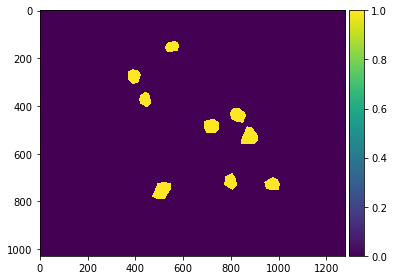

In [4]:
img = imgs[50]
annIds = coco.getAnnIds(imgIds=[img['id']])
anns = coco.loadAnns(annIds)
if len(anns) > 0:
    mask = coco.annToMask(anns[0])
    for i in range(1, len(anns)):
        mask += coco.annToMask(anns[i])
    im = Image.fromarray(mask)
imshow(np.array(im))
im.save('./tsu_ai_m2_dataset/masks/' + str(img['file_name'][9:][:-4]) + '_' + str(img['id']) + '.png')

In [5]:
CLASSES = 1

COLORS = ['orange']

SAMPLE_SIZE = (512, 512)

OUTPUT_SIZE = (1280, 1028)

In [6]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [7]:
# images = sorted(glob.glob('tsu_ai_m2_dataset/images/9/*.jpg'))[:284]
images = sorted(['tsu_ai_m2_dataset/' + img['file_name'][:8] + '\\' + img['file_name'][9:] for img in imgs])
masks = sorted(glob.glob('tsu_ai_m2_dataset/masks/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(5)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

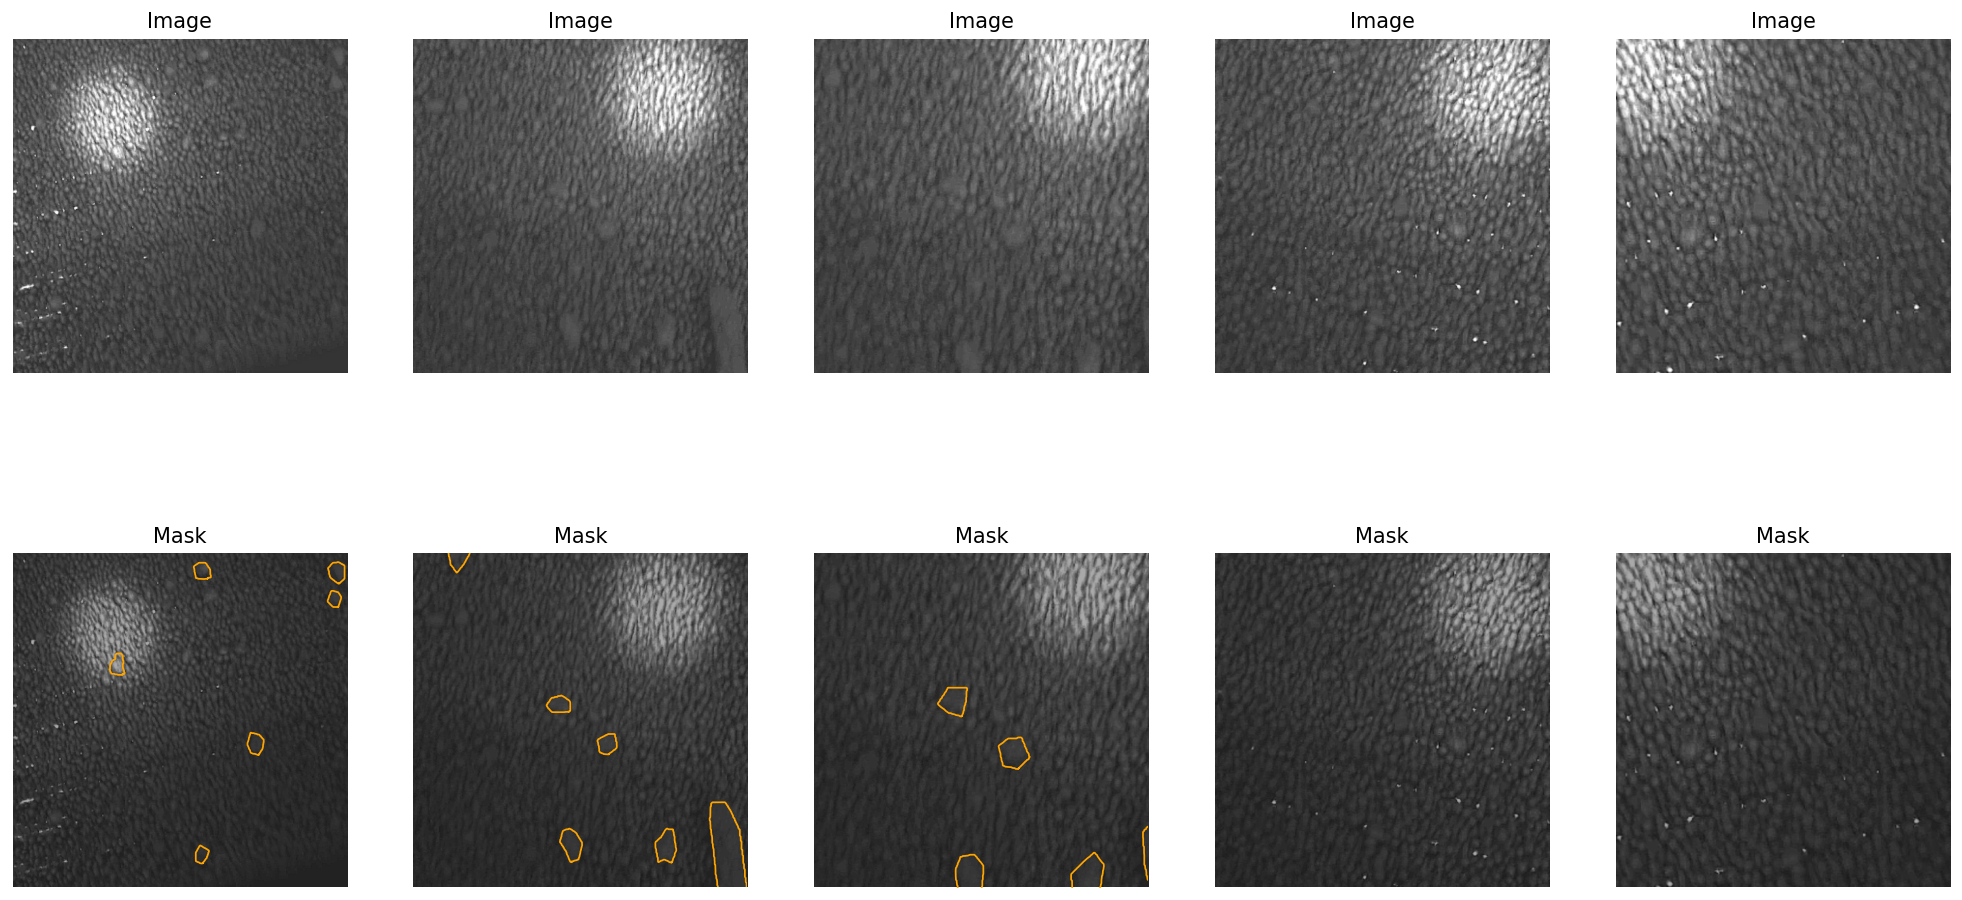

In [8]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(20, 10), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image / 1.5)
    
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

In [9]:
train_dataset = dataset.take(1200).cache()
test_dataset = dataset.skip(1200).take(300).cache()

train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

In [10]:
def custom_loss(y, y_pred):
    y = tf.unstack(y, axis=3)
    y_pred = tf.unstack(y_pred, axis=3)
    return tf.reduce_sum(tf.abs(tf.math.subtract(y, y_pred))) / (1280 * 1028)

In [11]:
im = np.array(list(dataset.take(1))[0][1])
im1 = im[:, :, 0]

C:\Users\fklas\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


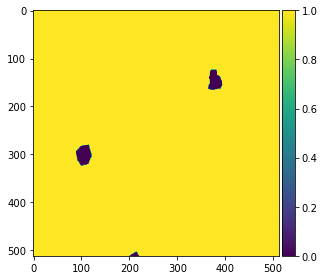

In [12]:
imshow(im1)

In [13]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

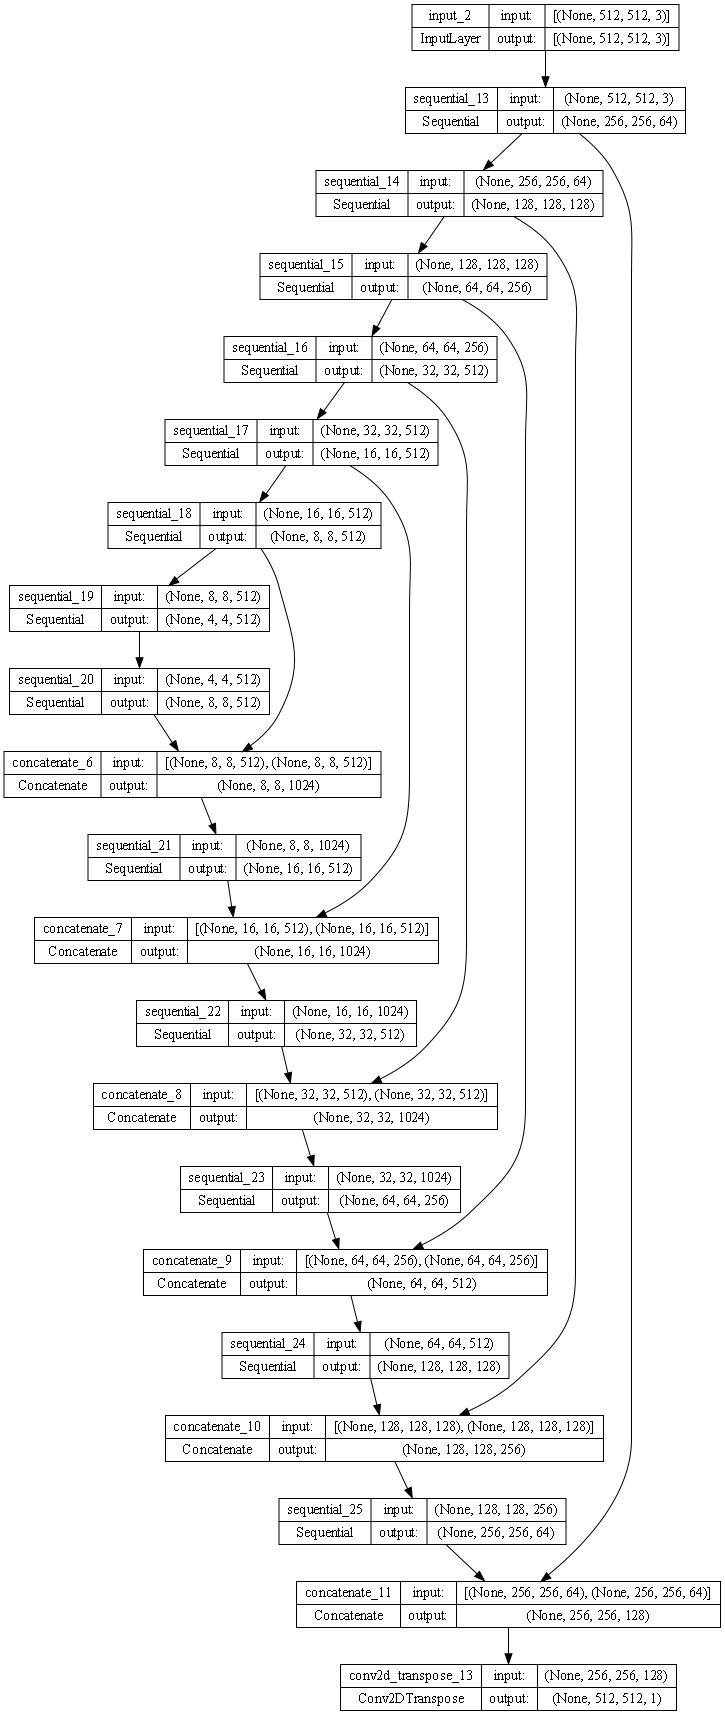

In [18]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

In [19]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [20]:
unet_like.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[dice_mc_metric])

In [21]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=20, initial_epoch=0)

unet_like.save_weights('SemanticSegmentationLesson/networks/unet_like_aug')

Epoch 1/20
150/150 [==============================] - 1797s 12s/step - loss: 0.1003 - dice_mc_metric: 0.9663 - val_loss: 0.1692 - val_dice_mc_metric: 0.9264
Epoch 2/20
150/150 [==============================] - 1823s 12s/step - loss: 0.0391 - dice_mc_metric: 0.9885 - val_loss: 0.0708 - val_dice_mc_metric: 0.9801
Epoch 3/20
150/150 [==============================] - 1817s 12s/step - loss: 0.0305 - dice_mc_metric: 0.9912 - val_loss: 0.0827 - val_dice_mc_metric: 0.9751
Epoch 4/20
150/150 [==============================] - 1811s 12s/step - loss: 0.0279 - dice_mc_metric: 0.9920 - val_loss: 0.0742 - val_dice_mc_metric: 0.9707
Epoch 5/20
150/150 [==============================] - 1836s 12s/step - loss: 0.0259 - dice_mc_metric: 0.9924 - val_loss: 0.0295 - val_dice_mc_metric: 0.9905
Epoch 6/20
150/150 [==============================] - 1576s 11s/step - loss: 0.0240 - dice_mc_metric: 0.9930 - val_loss: 0.0267 - val_dice_mc_metric: 0.9923
Epoch 7/20
150/150 [==============================] - 1236

In [22]:
unet_like.load_weights('SemanticSegmentationLesson/networks/unet_like_aug')

In [23]:
frames = sorted(glob.glob('tsu_ai_m2_dataset/images/*.jpg'))
filename = frames[10]
frame = imread(filename)
sample = resize(frame, SAMPLE_SIZE)

predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
# predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

1/1 [==============================] - 1s 912ms/step


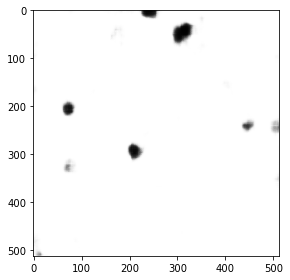

In [24]:
imshow(predict.squeeze()[:, :])

In [25]:
from tqdm import tqdm
rgb_colors = [
    (255, 255, 255)
]

frames = sorted(glob.glob('tsu_ai_m2_dataset/images/*.jpg'))

for filename in tqdm(frames):
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(0, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        for contour in contours:
            rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                       contour[:, 1] * scale[1],
                                       shape=contour_overlay.shape)

            contour_overlay[rr, cc] = 1 

        contour_overlay = dilation(contour_overlay, disk(1))
        frame[contour_overlay == 1] = rgb_colors[channel]

    imsave(f'tsu_ai_m2_dataset/test/{os.path.basename(filename)}', frame)

  0%|                                                                                          | 0/284 [00:00<?, ?it/s]

1/1 [==============================] - 0s 191ms/step


  0%|▎                                                                                 | 1/284 [00:00<02:21,  2.00it/s]

1/1 [==============================] - 0s 213ms/step


  1%|▌                                                                                 | 2/284 [00:01<02:23,  1.97it/s]

1/1 [==============================] - 0s 231ms/step


  1%|▊                                                                                 | 3/284 [00:01<02:26,  1.91it/s]

1/1 [==============================] - 0s 212ms/step


  1%|█▏                                                                                | 4/284 [00:02<02:23,  1.95it/s]

1/1 [==============================] - 0s 250ms/step


  2%|█▍                                                                                | 5/284 [00:02<02:24,  1.93it/s]

1/1 [==============================] - 0s 210ms/step


  2%|█▋                                                                                | 6/284 [00:03<02:25,  1.91it/s]

1/1 [==============================] - 0s 230ms/step


  2%|██                                                                                | 7/284 [00:03<02:25,  1.90it/s]

1/1 [==============================] - 0s 206ms/step


  3%|██▎                                                                               | 8/284 [00:04<02:23,  1.93it/s]

1/1 [==============================] - 0s 206ms/step


  3%|██▌                                                                               | 9/284 [00:04<02:21,  1.95it/s]

1/1 [==============================] - 0s 190ms/step


  4%|██▊                                                                              | 10/284 [00:05<02:16,  2.00it/s]

1/1 [==============================] - 0s 205ms/step


  4%|███▏                                                                             | 11/284 [00:05<02:14,  2.03it/s]

1/1 [==============================] - 0s 205ms/step


  4%|███▍                                                                             | 12/284 [00:06<02:13,  2.04it/s]

1/1 [==============================] - 0s 206ms/step


  5%|███▋                                                                             | 13/284 [00:06<02:12,  2.05it/s]

1/1 [==============================] - 0s 207ms/step


  5%|███▉                                                                             | 14/284 [00:07<02:10,  2.07it/s]

1/1 [==============================] - 0s 205ms/step


  5%|████▎                                                                            | 15/284 [00:07<02:07,  2.12it/s]

1/1 [==============================] - 0s 190ms/step


  6%|████▌                                                                            | 16/284 [00:07<02:07,  2.11it/s]

1/1 [==============================] - 0s 203ms/step


  6%|████▊                                                                            | 17/284 [00:08<02:06,  2.10it/s]

1/1 [==============================] - 0s 200ms/step


  6%|█████▏                                                                           | 18/284 [00:08<02:05,  2.12it/s]

1/1 [==============================] - 0s 227ms/step


  7%|█████▍                                                                           | 19/284 [00:09<02:06,  2.10it/s]

1/1 [==============================] - 0s 200ms/step


  7%|█████▋                                                                           | 20/284 [00:09<02:05,  2.10it/s]

1/1 [==============================] - 0s 205ms/step


  7%|█████▉                                                                           | 21/284 [00:10<02:04,  2.11it/s]

1/1 [==============================] - 0s 205ms/step


  8%|██████▎                                                                          | 22/284 [00:10<02:04,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


  8%|██████▌                                                                          | 23/284 [00:11<02:03,  2.11it/s]

1/1 [==============================] - 0s 205ms/step


  8%|██████▊                                                                          | 24/284 [00:11<02:03,  2.11it/s]

1/1 [==============================] - 0s 222ms/step


  9%|███████▏                                                                         | 25/284 [00:12<02:02,  2.11it/s]

1/1 [==============================] - 0s 208ms/step


  9%|███████▍                                                                         | 26/284 [00:12<02:03,  2.09it/s]

1/1 [==============================] - 0s 193ms/step


 10%|███████▋                                                                         | 27/284 [00:13<02:01,  2.12it/s]

1/1 [==============================] - 0s 206ms/step


 10%|███████▉                                                                         | 28/284 [00:13<01:59,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 10%|████████▎                                                                        | 29/284 [00:14<01:59,  2.13it/s]

1/1 [==============================] - 0s 222ms/step


 11%|████████▌                                                                        | 30/284 [00:14<02:00,  2.10it/s]

1/1 [==============================] - 0s 206ms/step


 11%|████████▊                                                                        | 31/284 [00:15<02:00,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 11%|█████████▏                                                                       | 32/284 [00:15<01:58,  2.13it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█████████▍                                                                       | 33/284 [00:16<02:00,  2.08it/s]

1/1 [==============================] - 0s 207ms/step


 12%|█████████▋                                                                       | 34/284 [00:16<02:00,  2.07it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█████████▉                                                                       | 35/284 [00:16<01:58,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 13%|██████████▎                                                                      | 36/284 [00:17<01:57,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 13%|██████████▌                                                                      | 37/284 [00:17<01:56,  2.13it/s]

1/1 [==============================] - 0s 206ms/step


 13%|██████████▊                                                                      | 38/284 [00:18<01:55,  2.12it/s]

1/1 [==============================] - 0s 192ms/step


 14%|███████████                                                                      | 39/284 [00:18<01:54,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


 14%|███████████▍                                                                     | 40/284 [00:19<01:54,  2.13it/s]

1/1 [==============================] - 0s 191ms/step


 14%|███████████▋                                                                     | 41/284 [00:19<01:53,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 15%|███████████▉                                                                     | 42/284 [00:20<01:51,  2.16it/s]

1/1 [==============================] - 0s 214ms/step


 15%|████████████▎                                                                    | 43/284 [00:20<01:52,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 15%|████████████▌                                                                    | 44/284 [00:21<01:52,  2.13it/s]

1/1 [==============================] - 0s 222ms/step


 16%|████████████▊                                                                    | 45/284 [00:21<01:52,  2.13it/s]

1/1 [==============================] - 0s 190ms/step


 16%|█████████████                                                                    | 46/284 [00:22<01:52,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 17%|█████████████▍                                                                   | 47/284 [00:22<01:51,  2.12it/s]

1/1 [==============================] - 0s 203ms/step


 17%|█████████████▋                                                                   | 48/284 [00:23<01:51,  2.12it/s]

1/1 [==============================] - 0s 206ms/step


 17%|█████████████▉                                                                   | 49/284 [00:23<01:50,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 18%|██████████████▎                                                                  | 50/284 [00:24<01:50,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 18%|██████████████▌                                                                  | 51/284 [00:24<01:48,  2.14it/s]

1/1 [==============================] - 0s 189ms/step


 18%|██████████████▊                                                                  | 52/284 [00:24<01:49,  2.11it/s]

1/1 [==============================] - 0s 221ms/step


 19%|███████████████                                                                  | 53/284 [00:25<01:50,  2.09it/s]

1/1 [==============================] - 0s 221ms/step


 19%|███████████████▍                                                                 | 54/284 [00:25<01:50,  2.08it/s]

1/1 [==============================] - 0s 205ms/step


 19%|███████████████▋                                                                 | 55/284 [00:26<01:48,  2.11it/s]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▉                                                                 | 56/284 [00:26<01:47,  2.12it/s]

1/1 [==============================] - 0s 221ms/step


 20%|████████████████▎                                                                | 57/284 [00:27<01:48,  2.09it/s]

1/1 [==============================] - 0s 216ms/step


 20%|████████████████▌                                                                | 58/284 [00:27<01:48,  2.09it/s]

1/1 [==============================] - 0s 193ms/step


 21%|████████████████▊                                                                | 59/284 [00:28<01:48,  2.08it/s]

1/1 [==============================] - 0s 217ms/step


 21%|█████████████████                                                                | 60/284 [00:28<01:46,  2.10it/s]

1/1 [==============================] - 0s 187ms/step


 21%|█████████████████▍                                                               | 61/284 [00:29<01:45,  2.11it/s]

1/1 [==============================] - 0s 213ms/step


 22%|█████████████████▋                                                               | 62/284 [00:29<01:43,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 22%|█████████████████▉                                                               | 63/284 [00:30<01:43,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 23%|██████████████████▎                                                              | 64/284 [00:30<01:42,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 23%|██████████████████▌                                                              | 65/284 [00:31<01:41,  2.17it/s]

1/1 [==============================] - 0s 219ms/step


 23%|██████████████████▊                                                              | 66/284 [00:31<01:43,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 24%|███████████████████                                                              | 67/284 [00:32<01:42,  2.12it/s]

1/1 [==============================] - 0s 206ms/step


 24%|███████████████████▍                                                             | 68/284 [00:32<01:41,  2.13it/s]

1/1 [==============================] - 0s 206ms/step


 24%|███████████████████▋                                                             | 69/284 [00:32<01:41,  2.11it/s]

1/1 [==============================] - 0s 190ms/step


 25%|███████████████████▉                                                             | 70/284 [00:33<01:41,  2.10it/s]

1/1 [==============================] - 0s 205ms/step


 25%|████████████████████▎                                                            | 71/284 [00:33<01:39,  2.13it/s]

1/1 [==============================] - 0s 207ms/step


 25%|████████████████████▌                                                            | 72/284 [00:34<01:38,  2.16it/s]

1/1 [==============================] - 0s 190ms/step


 26%|████████████████████▊                                                            | 73/284 [00:34<01:37,  2.16it/s]

1/1 [==============================] - 0s 206ms/step


 26%|█████████████████████                                                            | 74/284 [00:35<01:37,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 26%|█████████████████████▍                                                           | 75/284 [00:35<01:36,  2.17it/s]

1/1 [==============================] - 0s 205ms/step


 27%|█████████████████████▋                                                           | 76/284 [00:36<01:36,  2.16it/s]

1/1 [==============================] - 0s 206ms/step


 27%|█████████████████████▉                                                           | 77/284 [00:36<01:36,  2.16it/s]

1/1 [==============================] - 0s 216ms/step


 27%|██████████████████████▏                                                          | 78/284 [00:37<01:34,  2.18it/s]

1/1 [==============================] - 0s 205ms/step


 28%|██████████████████████▌                                                          | 79/284 [00:37<01:34,  2.17it/s]

1/1 [==============================] - 0s 192ms/step


 28%|██████████████████████▊                                                          | 80/284 [00:38<01:33,  2.18it/s]

1/1 [==============================] - 0s 206ms/step


 29%|███████████████████████                                                          | 81/284 [00:38<01:33,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 29%|███████████████████████▍                                                         | 82/284 [00:39<01:35,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 29%|███████████████████████▋                                                         | 83/284 [00:39<01:33,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 30%|███████████████████████▉                                                         | 84/284 [00:39<01:32,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 30%|████████████████████████▏                                                        | 85/284 [00:40<01:32,  2.16it/s]

1/1 [==============================] - 0s 204ms/step


 30%|████████████████████████▌                                                        | 86/284 [00:40<01:31,  2.16it/s]

1/1 [==============================] - 0s 189ms/step


 31%|████████████████████████▊                                                        | 87/284 [00:41<01:30,  2.17it/s]

1/1 [==============================] - 0s 189ms/step


 31%|█████████████████████████                                                        | 88/284 [00:41<01:30,  2.16it/s]

1/1 [==============================] - 0s 206ms/step


 31%|█████████████████████████▍                                                       | 89/284 [00:42<01:30,  2.16it/s]

1/1 [==============================] - 0s 220ms/step


 32%|█████████████████████████▋                                                       | 90/284 [00:42<01:31,  2.13it/s]

1/1 [==============================] - 0s 206ms/step


 32%|█████████████████████████▉                                                       | 91/284 [00:43<01:30,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 32%|██████████████████████████▏                                                      | 92/284 [00:43<01:31,  2.10it/s]

1/1 [==============================] - 0s 189ms/step


 33%|██████████████████████████▌                                                      | 93/284 [00:44<01:29,  2.13it/s]

1/1 [==============================] - 0s 190ms/step


 33%|██████████████████████████▊                                                      | 94/284 [00:44<01:29,  2.13it/s]

1/1 [==============================] - 0s 206ms/step


 33%|███████████████████████████                                                      | 95/284 [00:45<01:29,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 34%|███████████████████████████▍                                                     | 96/284 [00:45<01:28,  2.12it/s]

1/1 [==============================] - 0s 189ms/step


 34%|███████████████████████████▋                                                     | 97/284 [00:45<01:25,  2.18it/s]

1/1 [==============================] - 0s 203ms/step


 35%|███████████████████████████▉                                                     | 98/284 [00:46<01:26,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 35%|████████████████████████████▏                                                    | 99/284 [00:46<01:26,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 35%|████████████████████████████▏                                                   | 100/284 [00:47<01:25,  2.14it/s]

1/1 [==============================] - 0s 189ms/step


 36%|████████████████████████████▍                                                   | 101/284 [00:47<01:24,  2.17it/s]

1/1 [==============================] - 0s 206ms/step


 36%|████████████████████████████▋                                                   | 102/284 [00:48<01:25,  2.14it/s]

1/1 [==============================] - 0s 204ms/step


 36%|█████████████████████████████                                                   | 103/284 [00:48<01:23,  2.16it/s]

1/1 [==============================] - 0s 189ms/step


 37%|█████████████████████████████▎                                                  | 104/284 [00:49<01:23,  2.15it/s]

1/1 [==============================] - 0s 204ms/step


 37%|█████████████████████████████▌                                                  | 105/284 [00:49<01:24,  2.13it/s]

1/1 [==============================] - 0s 190ms/step


 37%|█████████████████████████████▊                                                  | 106/284 [00:50<01:24,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 38%|██████████████████████████████▏                                                 | 107/284 [00:50<01:23,  2.12it/s]

1/1 [==============================] - 0s 204ms/step


 38%|██████████████████████████████▍                                                 | 108/284 [00:51<01:21,  2.15it/s]

1/1 [==============================] - 0s 189ms/step


 38%|██████████████████████████████▋                                                 | 109/284 [00:51<01:20,  2.17it/s]

1/1 [==============================] - 0s 189ms/step


 39%|██████████████████████████████▉                                                 | 110/284 [00:52<01:19,  2.19it/s]

1/1 [==============================] - 0s 191ms/step


 39%|███████████████████████████████▎                                                | 111/284 [00:52<01:19,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 39%|███████████████████████████████▌                                                | 112/284 [00:52<01:19,  2.17it/s]

1/1 [==============================] - 0s 206ms/step


 40%|███████████████████████████████▊                                                | 113/284 [00:53<01:19,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 40%|████████████████████████████████                                                | 114/284 [00:53<01:18,  2.17it/s]

1/1 [==============================] - 0s 189ms/step


 40%|████████████████████████████████▍                                               | 115/284 [00:54<01:17,  2.17it/s]

1/1 [==============================] - 0s 190ms/step


 41%|████████████████████████████████▋                                               | 116/284 [00:54<01:17,  2.18it/s]

1/1 [==============================] - 0s 205ms/step


 41%|████████████████████████████████▉                                               | 117/284 [00:55<01:16,  2.17it/s]

1/1 [==============================] - 0s 205ms/step


 42%|█████████████████████████████████▏                                              | 118/284 [00:55<01:16,  2.16it/s]

1/1 [==============================] - 0s 206ms/step


 42%|█████████████████████████████████▌                                              | 119/284 [00:56<01:16,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 42%|█████████████████████████████████▊                                              | 120/284 [00:56<01:16,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 43%|██████████████████████████████████                                              | 121/284 [00:57<01:15,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 43%|██████████████████████████████████▎                                             | 122/284 [00:57<01:16,  2.13it/s]

1/1 [==============================] - 0s 207ms/step


 43%|██████████████████████████████████▋                                             | 123/284 [00:58<01:17,  2.09it/s]

1/1 [==============================] - 0s 206ms/step


 44%|██████████████████████████████████▉                                             | 124/284 [00:58<01:16,  2.10it/s]

1/1 [==============================] - 0s 190ms/step


 44%|███████████████████████████████████▏                                            | 125/284 [00:59<01:15,  2.09it/s]

1/1 [==============================] - 0s 205ms/step


 44%|███████████████████████████████████▍                                            | 126/284 [00:59<01:14,  2.11it/s]

1/1 [==============================] - 0s 205ms/step


 45%|███████████████████████████████████▊                                            | 127/284 [01:00<01:14,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 45%|████████████████████████████████████                                            | 128/284 [01:00<01:13,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 45%|████████████████████████████████████▎                                           | 129/284 [01:00<01:12,  2.13it/s]

1/1 [==============================] - 0s 190ms/step


 46%|████████████████████████████████████▌                                           | 130/284 [01:01<01:11,  2.16it/s]

1/1 [==============================] - 0s 189ms/step


 46%|████████████████████████████████████▉                                           | 131/284 [01:01<01:11,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 46%|█████████████████████████████████████▏                                          | 132/284 [01:02<01:09,  2.17it/s]

1/1 [==============================] - 0s 206ms/step


 47%|█████████████████████████████████████▍                                          | 133/284 [01:02<01:09,  2.17it/s]

1/1 [==============================] - 0s 195ms/step


 47%|█████████████████████████████████████▋                                          | 134/284 [01:03<01:09,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 48%|██████████████████████████████████████                                          | 135/284 [01:03<01:08,  2.18it/s]

1/1 [==============================] - 0s 205ms/step


 48%|██████████████████████████████████████▎                                         | 136/284 [01:04<01:07,  2.19it/s]

1/1 [==============================] - 0s 211ms/step


 48%|██████████████████████████████████████▌                                         | 137/284 [01:04<01:07,  2.17it/s]

1/1 [==============================] - 0s 205ms/step


 49%|██████████████████████████████████████▊                                         | 138/284 [01:05<01:07,  2.17it/s]

1/1 [==============================] - 0s 206ms/step


 49%|███████████████████████████████████████▏                                        | 139/284 [01:05<01:07,  2.16it/s]

1/1 [==============================] - 0s 199ms/step


 49%|███████████████████████████████████████▍                                        | 140/284 [01:06<01:06,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 50%|███████████████████████████████████████▋                                        | 141/284 [01:06<01:05,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 50%|████████████████████████████████████████                                        | 142/284 [01:06<01:05,  2.17it/s]

1/1 [==============================] - 0s 205ms/step


 50%|████████████████████████████████████████▎                                       | 143/284 [01:07<01:05,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 51%|████████████████████████████████████████▌                                       | 144/284 [01:07<01:05,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 51%|████████████████████████████████████████▊                                       | 145/284 [01:08<01:04,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 51%|█████████████████████████████████████████▏                                      | 146/284 [01:08<01:04,  2.15it/s]

1/1 [==============================] - 0s 190ms/step


 52%|█████████████████████████████████████████▍                                      | 147/284 [01:09<01:03,  2.15it/s]

1/1 [==============================] - 0s 190ms/step


 52%|█████████████████████████████████████████▋                                      | 148/284 [01:09<01:02,  2.17it/s]

1/1 [==============================] - 0s 189ms/step


 52%|█████████████████████████████████████████▉                                      | 149/284 [01:10<01:01,  2.18it/s]

1/1 [==============================] - 0s 190ms/step


 53%|██████████████████████████████████████████▎                                     | 150/284 [01:10<01:01,  2.20it/s]

1/1 [==============================] - 0s 188ms/step


 53%|██████████████████████████████████████████▌                                     | 151/284 [01:11<01:01,  2.16it/s]

1/1 [==============================] - 0s 191ms/step


 54%|██████████████████████████████████████████▊                                     | 152/284 [01:11<01:00,  2.18it/s]

1/1 [==============================] - 0s 206ms/step


 54%|███████████████████████████████████████████                                     | 153/284 [01:12<01:00,  2.17it/s]

1/1 [==============================] - 0s 190ms/step


 54%|███████████████████████████████████████████▍                                    | 154/284 [01:12<01:00,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 55%|███████████████████████████████████████████▋                                    | 155/284 [01:12<00:59,  2.17it/s]

1/1 [==============================] - 0s 189ms/step


 55%|███████████████████████████████████████████▉                                    | 156/284 [01:13<00:59,  2.17it/s]

1/1 [==============================] - 0s 190ms/step


 55%|████████████████████████████████████████████▏                                   | 157/284 [01:13<00:58,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 56%|████████████████████████████████████████████▌                                   | 158/284 [01:14<01:00,  2.09it/s]

1/1 [==============================] - 0s 205ms/step


 56%|████████████████████████████████████████████▊                                   | 159/284 [01:14<00:59,  2.10it/s]

1/1 [==============================] - 0s 189ms/step


 56%|█████████████████████████████████████████████                                   | 160/284 [01:15<00:59,  2.09it/s]

1/1 [==============================] - 0s 205ms/step


 57%|█████████████████████████████████████████████▎                                  | 161/284 [01:15<00:58,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 57%|█████████████████████████████████████████████▋                                  | 162/284 [01:16<00:57,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 57%|█████████████████████████████████████████████▉                                  | 163/284 [01:16<00:56,  2.12it/s]

1/1 [==============================] - 0s 190ms/step


 58%|██████████████████████████████████████████████▏                                 | 164/284 [01:17<00:56,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 58%|██████████████████████████████████████████████▍                                 | 165/284 [01:17<00:55,  2.14it/s]

1/1 [==============================] - 0s 209ms/step


 58%|██████████████████████████████████████████████▊                                 | 166/284 [01:18<00:56,  2.10it/s]

1/1 [==============================] - 0s 205ms/step


 59%|███████████████████████████████████████████████                                 | 167/284 [01:18<00:55,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 59%|███████████████████████████████████████████████▎                                | 168/284 [01:19<00:54,  2.13it/s]

1/1 [==============================] - 0s 190ms/step


 60%|███████████████████████████████████████████████▌                                | 169/284 [01:19<00:54,  2.12it/s]

1/1 [==============================] - 0s 206ms/step


 60%|███████████████████████████████████████████████▉                                | 170/284 [01:20<00:53,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 60%|████████████████████████████████████████████████▏                               | 171/284 [01:20<00:52,  2.14it/s]

1/1 [==============================] - 0s 224ms/step


 61%|████████████████████████████████████████████████▍                               | 172/284 [01:20<00:52,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 61%|████████████████████████████████████████████████▋                               | 173/284 [01:21<00:52,  2.13it/s]

1/1 [==============================] - 0s 190ms/step


 61%|█████████████████████████████████████████████████                               | 174/284 [01:21<00:51,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 62%|█████████████████████████████████████████████████▎                              | 175/284 [01:22<00:51,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 62%|█████████████████████████████████████████████████▌                              | 176/284 [01:22<00:51,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 62%|█████████████████████████████████████████████████▊                              | 177/284 [01:23<00:50,  2.12it/s]

1/1 [==============================] - 0s 189ms/step


 63%|██████████████████████████████████████████████████▏                             | 178/284 [01:23<00:49,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 63%|██████████████████████████████████████████████████▍                             | 179/284 [01:24<00:49,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 63%|██████████████████████████████████████████████████▋                             | 180/284 [01:24<00:48,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 64%|██████████████████████████████████████████████████▉                             | 181/284 [01:25<00:48,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 64%|███████████████████████████████████████████████████▎                            | 182/284 [01:25<00:47,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 64%|███████████████████████████████████████████████████▌                            | 183/284 [01:26<00:47,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 65%|███████████████████████████████████████████████████▊                            | 184/284 [01:26<00:46,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 65%|████████████████████████████████████████████████████                            | 185/284 [01:27<00:45,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 65%|████████████████████████████████████████████████████▍                           | 186/284 [01:27<00:45,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 66%|████████████████████████████████████████████████████▋                           | 187/284 [01:27<00:45,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 66%|████████████████████████████████████████████████████▉                           | 188/284 [01:28<00:44,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


 67%|█████████████████████████████████████████████████████▏                          | 189/284 [01:28<00:44,  2.14it/s]

1/1 [==============================] - 0s 204ms/step


 67%|█████████████████████████████████████████████████████▌                          | 190/284 [01:29<00:43,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 67%|█████████████████████████████████████████████████████▊                          | 191/284 [01:29<00:43,  2.16it/s]

1/1 [==============================] - 0s 189ms/step


 68%|██████████████████████████████████████████████████████                          | 192/284 [01:30<00:42,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 68%|██████████████████████████████████████████████████████▎                         | 193/284 [01:30<00:42,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 68%|██████████████████████████████████████████████████████▋                         | 194/284 [01:31<00:41,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 69%|██████████████████████████████████████████████████████▉                         | 195/284 [01:31<00:41,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 69%|███████████████████████████████████████████████████████▏                        | 196/284 [01:32<00:40,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 69%|███████████████████████████████████████████████████████▍                        | 197/284 [01:32<00:40,  2.16it/s]

1/1 [==============================] - 0s 214ms/step


 70%|███████████████████████████████████████████████████████▊                        | 198/284 [01:33<00:39,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 70%|████████████████████████████████████████████████████████                        | 199/284 [01:33<00:39,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 70%|████████████████████████████████████████████████████████▎                       | 200/284 [01:34<00:39,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 71%|████████████████████████████████████████████████████████▌                       | 201/284 [01:34<00:38,  2.15it/s]

1/1 [==============================] - 0s 190ms/step


 71%|████████████████████████████████████████████████████████▉                       | 202/284 [01:34<00:38,  2.15it/s]

1/1 [==============================] - 0s 207ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 203/284 [01:35<00:37,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 204/284 [01:35<00:37,  2.14it/s]

1/1 [==============================] - 0s 189ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 205/284 [01:36<00:36,  2.15it/s]

1/1 [==============================] - 0s 190ms/step


 73%|██████████████████████████████████████████████████████████                      | 206/284 [01:36<00:36,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 207/284 [01:37<00:36,  2.10it/s]

1/1 [==============================] - 0s 189ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 208/284 [01:37<00:35,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 209/284 [01:38<00:35,  2.08it/s]

1/1 [==============================] - 0s 197ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 210/284 [01:38<00:35,  2.10it/s]

1/1 [==============================] - 0s 218ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 211/284 [01:39<00:34,  2.13it/s]

1/1 [==============================] - 0s 219ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 212/284 [01:39<00:34,  2.10it/s]

1/1 [==============================] - 0s 198ms/step


 75%|████████████████████████████████████████████████████████████                    | 213/284 [01:40<00:33,  2.12it/s]

1/1 [==============================] - 0s 190ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 214/284 [01:40<00:32,  2.15it/s]

1/1 [==============================] - 0s 189ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 215/284 [01:41<00:32,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 216/284 [01:41<00:31,  2.17it/s]

1/1 [==============================] - 0s 196ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 217/284 [01:41<00:30,  2.19it/s]

1/1 [==============================] - 0s 190ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 218/284 [01:42<00:30,  2.20it/s]

1/1 [==============================] - 0s 189ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 219/284 [01:42<00:29,  2.20it/s]

1/1 [==============================] - 0s 206ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 220/284 [01:43<00:29,  2.19it/s]

1/1 [==============================] - 0s 190ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 221/284 [01:43<00:28,  2.20it/s]

1/1 [==============================] - 0s 205ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 222/284 [01:44<00:28,  2.18it/s]

1/1 [==============================] - 0s 205ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 223/284 [01:44<00:28,  2.17it/s]

1/1 [==============================] - 0s 190ms/step


 79%|███████████████████████████████████████████████████████████████                 | 224/284 [01:45<00:27,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 225/284 [01:45<00:27,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 226/284 [01:46<00:27,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 227/284 [01:46<00:26,  2.15it/s]

1/1 [==============================] - 0s 190ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 228/284 [01:47<00:26,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 229/284 [01:47<00:25,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 230/284 [01:47<00:25,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


 81%|█████████████████████████████████████████████████████████████████               | 231/284 [01:48<00:24,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 232/284 [01:48<00:24,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 233/284 [01:49<00:24,  2.12it/s]

1/1 [==============================] - 0s 190ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 234/284 [01:49<00:23,  2.15it/s]

1/1 [==============================] - 0s 189ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 235/284 [01:50<00:22,  2.15it/s]

1/1 [==============================] - 0s 190ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 236/284 [01:50<00:22,  2.15it/s]

1/1 [==============================] - 0s 190ms/step


 83%|██████████████████████████████████████████████████████████████████▊             | 237/284 [01:51<00:22,  2.12it/s]

1/1 [==============================] - 0s 208ms/step


 84%|███████████████████████████████████████████████████████████████████             | 238/284 [01:51<00:22,  2.09it/s]

1/1 [==============================] - 0s 191ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 239/284 [01:52<00:21,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 85%|███████████████████████████████████████████████████████████████████▌            | 240/284 [01:52<00:20,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 241/284 [01:53<00:20,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 242/284 [01:53<00:19,  2.12it/s]

1/1 [==============================] - 0s 204ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 243/284 [01:54<00:19,  2.14it/s]

1/1 [==============================] - 0s 189ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 244/284 [01:54<00:18,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 245/284 [01:54<00:18,  2.17it/s]

1/1 [==============================] - 0s 205ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 246/284 [01:55<00:17,  2.16it/s]

1/1 [==============================] - 0s 189ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 247/284 [01:55<00:17,  2.17it/s]

1/1 [==============================] - 0s 205ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 248/284 [01:56<00:16,  2.17it/s]

1/1 [==============================] - 0s 190ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 249/284 [01:56<00:16,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 250/284 [01:57<00:15,  2.16it/s]

1/1 [==============================] - 0s 190ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 251/284 [01:57<00:15,  2.15it/s]

1/1 [==============================] - 0s 201ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 252/284 [01:58<00:14,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 253/284 [01:58<00:14,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 254/284 [01:59<00:14,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 255/284 [01:59<00:13,  2.11it/s]

1/1 [==============================] - 0s 206ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 256/284 [02:00<00:13,  2.12it/s]

1/1 [==============================] - 0s 189ms/step


 90%|████████████████████████████████████████████████████████████████████████▍       | 257/284 [02:00<00:12,  2.13it/s]

1/1 [==============================] - 0s 206ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 258/284 [02:01<00:12,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 259/284 [02:01<00:11,  2.11it/s]

1/1 [==============================] - 0s 190ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 260/284 [02:02<00:11,  2.12it/s]

1/1 [==============================] - 0s 205ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 261/284 [02:02<00:10,  2.13it/s]

1/1 [==============================] - 0s 205ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 262/284 [02:02<00:10,  2.13it/s]

1/1 [==============================] - 0s 206ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 263/284 [02:03<00:09,  2.14it/s]

1/1 [==============================] - 0s 189ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 264/284 [02:03<00:09,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 265/284 [02:04<00:08,  2.14it/s]

1/1 [==============================] - 0s 206ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 266/284 [02:04<00:08,  2.11it/s]

1/1 [==============================] - 0s 205ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 267/284 [02:05<00:07,  2.15it/s]

1/1 [==============================] - 0s 205ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 268/284 [02:05<00:07,  2.17it/s]

1/1 [==============================] - 0s 205ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 269/284 [02:06<00:06,  2.14it/s]

1/1 [==============================] - 0s 205ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 270/284 [02:06<00:06,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 271/284 [02:07<00:06,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 272/284 [02:07<00:05,  2.13it/s]

1/1 [==============================] - 0s 213ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 273/284 [02:08<00:05,  2.14it/s]

1/1 [==============================] - 0s 194ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 274/284 [02:08<00:04,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 275/284 [02:08<00:04,  2.16it/s]

1/1 [==============================] - 0s 189ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 276/284 [02:09<00:03,  2.18it/s]

1/1 [==============================] - 0s 205ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 277/284 [02:09<00:03,  2.17it/s]

1/1 [==============================] - 0s 191ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 278/284 [02:10<00:02,  2.16it/s]

1/1 [==============================] - 0s 204ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 279/284 [02:10<00:02,  2.18it/s]

1/1 [==============================] - 0s 191ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 280/284 [02:11<00:01,  2.17it/s]

1/1 [==============================] - 0s 189ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 281/284 [02:11<00:01,  2.16it/s]

1/1 [==============================] - 0s 205ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 282/284 [02:12<00:00,  2.18it/s]

1/1 [==============================] - 0s 206ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 283/284 [02:12<00:00,  2.17it/s]

1/1 [==============================] - 0s 196ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:13<00:00,  2.13it/s]


In [49]:
frame

array([[[69, 69, 69],
        [47, 47, 47],
        [51, 51, 51],
        ...,
        [60, 60, 60],
        [41, 41, 41],
        [46, 46, 46]],

       [[48, 48, 48],
        [49, 49, 49],
        [55, 55, 55],
        ...,
        [46, 46, 46],
        [42, 42, 42],
        [43, 43, 43]],

       [[58, 58, 58],
        [58, 58, 58],
        [42, 42, 42],
        ...,
        [44, 44, 44],
        [44, 44, 44],
        [47, 47, 47]],

       ...,

       [[30, 30, 30],
        [30, 30, 30],
        [30, 30, 30],
        ...,
        [30, 30, 30],
        [30, 30, 30],
        [30, 30, 30]],

       [[30, 30, 30],
        [30, 30, 30],
        [30, 30, 30],
        ...,
        [30, 30, 30],
        [30, 30, 30],
        [30, 30, 30]],

       [[30, 30, 30],
        [30, 30, 30],
        [30, 30, 30],
        ...,
        [30, 30, 30],
        [30, 30, 30],
        [30, 30, 30]]], dtype=uint8)